<a href="https://colab.research.google.com/github/Oskarino/Lab5_PTD/blob/main/Lab5_PTD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import math
from functools import partial
from math import sin, cos, pi, sqrt, log
from scipy.fft import fft
import time
import numpy as np

In [2]:
#czestotliwosc probkowania
f_s = 8000
#przesuniecie w fazie
phi = pi/120

#funkcja pomocnaicza dla skali decybelowej
def table_log(seq):
  return [log(el,10) for el in seq]
   
def decimalToBinary(n,bits=7):
  ''' Transformacja zapisu dziesietnego do binarnego pojedynczego znaku'''
  zeros = [0 for _ in range(bits)]
  result = [int(digit) for digit in bin(n).replace("0b", "")]
  n = len(result)
  zeros[-n:] = result
  return zeros

def generate_signal(funkcja, f_s, T):
  ''' Funkcja generujaca sygnal dla funkcji: funkcja, czestotliwosci: f_s i czasu trwania T'''
  return [funkcja(n/f_s) for n in range(int(T*f_s))]

def widmo_amplitudowe(X):
  '''Obliczamy widno amplitudowe dla ciagu X'''
  return [ sqrt(X[k].real**2 + X[k].imag**2) for k in range(len(X))]

def to_binary(kod):
  ''' Transformacja calego kodu'''
  result = []
  for number in kod:
    result.extend(decimalToBinary(number))
  return result



def ASK(sygnal_modulujacy):
  '''Funkcja wykonujaca modulacje ASK'''
  sygnal = []
  #wzor modulacji
  funkcja = lambda t, A_n: A_n*sin(2*pi*f_n*t + phi_n)
  for n, b in zip(range(int(T*f_s)), sygnal_modulujacy):
    if b ==0:
      sygnal.append(funkcja(n/f_s, A_1))
    if b ==1:
      sygnal.append(funkcja(n/f_s, A_2))
  return sygnal


def PSK(sygnal_modulujacy):
  '''Funkcja wykonujaca modulacje PSK'''
  sygnal = []
  funkcja = lambda t, phi_n: sin(2*pi*f_n*t + phi_n)
  for n, b in zip(range(int(T*f_s)), sygnal_modulujacy):
    if b ==0:
      phi_n = 0
      sygnal.append(funkcja(n/f_s, phi_n))
    if b ==1:
      phi_n = pi
      sygnal.append(funkcja(n/f_s, phi_n))
  return sygnal

  
def FSK(sygnal_modulujacy):
  '''Funkcja wykonujaca modulacje FSK'''
  sygnal = []
  funkcja = lambda t, f_n: sin(2*pi*f_n*t )
  for n, b in zip(range(int(T*f_s)), sygnal_modulujacy):
    if b ==0:
      f_n = f_n1
      sygnal.append(funkcja(n/f_s, f_n))
    if b ==1:
      f_n = f_n2
      sygnal.append(funkcja(n/f_s, f_n))
  return sygnal

## Zadanie 5

In [3]:
#losowy kod ASCII
T=2 
import random
kod = []
_len = T

for i in range(_len):
  kod.append(random.randint(32,127))

m = to_binary(kod)

#czestotliowsci
f_m = 200
f_n = 500
M = len(m)
Tb=T/M 
Tbp=int(Tb*f_s) 
N=int(T*f_s) 

A_1=1.5 
A_2=2.5 
f_n = 500
phi_n = pi/8

def demodulacja_ASK(sygnal_ask, h, f_n, A):
  '''Uklad demodulacji sygnalu ASK'''
  funkcja_m = lambda t: A*sin(2*pi*f_n*t)
  inny_sygnal = generate_signal(funkcja_m, f_m, T)

  #mnozenie
  x = [s1*s2 for s1, s2 in zip(sygnal_ask, inny_sygnal)]

  #calka
  p = []
  for i in range(0, M+1):      
    p.append(np.sum(x[i-np.mod(i,Tbp):i]))  

  c = [1 if el > h  else 0 for el in p]
  return x, p, c

def demodulacja_PSK(sygnal_ask, f_n, A):
  funkcja_m = lambda t: A*sin(2*pi*f_n*t)
  inny_sygnal = generate_signal(funkcja_m, f_m, T)
  
  #mnozenie
  x = [s1*s2 for s1, s2 in zip(sygnal_ask, inny_sygnal)]

  #calka
  p = []
  for i in range(0, M+1):      
    p.append(np.sum(x[i-np.mod(i,Tbp):i]))  

  c = [1 if el < 0  else 0 for el in p]
  return x, p, c

def demodulacja_FSK(sygnal_fsk,  f_n1, f_n2, A):
  funkcja_m_1 = lambda t: A*sin(2*pi*f_n1*t)
  funkcja_m_2 = lambda t: A*sin(2*pi*f_n2*t)
  inny_sygnal_1 = generate_signal(funkcja_m_1, f_m, T)
  inny_sygnal_2 = generate_signal(funkcja_m_2, f_m, T)

  #mnozenie
  x1 = [s1*s2 for s1, s2 in zip(sygnal_ask, inny_sygnal_1)]

  #calka
  p1 = []
  for i in range(0, M+1):      
    p1.append(np.sum(x1[i-np.mod(i,Tbp):i]))  

  #mnozenie
  x2 = [s1*s2 for s1, s2 in zip(sygnal_ask, inny_sygnal_2)]

  #calka
  p2 = []
  for i in range(0, M+1):      
    p2.append(np.sum(x2[i-np.mod(i,Tbp):i]))  

  c = [1 if el2 - el1 > 0  else 0 for el1, el2 in zip(p1,p2)]


  return x1, x2, p1, p2, c

In [4]:
sygnal_ask = ASK(to_binary(kod))
h=0.0
A=A_1
x, p, c = demodulacja_ASK(sygnal_ask, h, f_n, A)

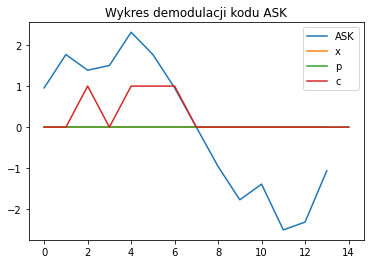

In [5]:
plt.plot(range(len(sygnal_ask)), sygnal_ask, label="ASK")
plt.plot(range(len(x)), x, label="x")
plt.plot(range(len(p)), p, label="p")
plt.plot(range(len(c)), c, label="c")
plt.title("Wykres demodulacji kodu ASK")
plt.legend()
plt.show()

In [6]:
sygnal_psk = PSK(to_binary(kod))
A=A_1
x, p, c = demodulacja_PSK(sygnal_psk, f_n, A)

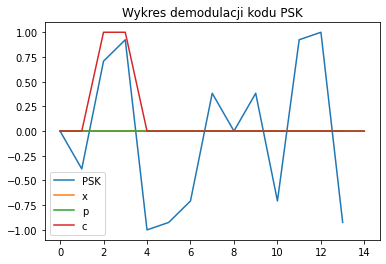

In [7]:
plt.plot(range(len(sygnal_psk)), sygnal_psk, label="PSK")
plt.plot(range(len(x)), x, label="x")
plt.plot(range(len(p)), p, label="p")
plt.plot(range(len(c)), c, label="c")
plt.title("Wykres demodulacji kodu PSK")
plt.legend()
plt.show()

In [8]:
W = 5

#liczba bitow sygnalu informacyjnego
B = 82
T_b = T/ B
#czestotliowsci obliczone zgodnie ze wzoramni
f_n1 = (W +1)/T_b
f_n2 = (W +2)/T_b


sygnal_fsk = FSK(to_binary(kod))
A=A_1
x1, x2, p1, p2, c = demodulacja_FSK(sygnal_fsk,  f_n1, f_n2, A)


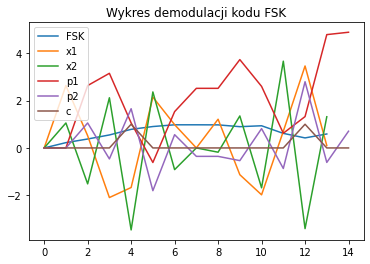

In [9]:
plt.plot(range(len(sygnal_fsk)), sygnal_fsk, label="FSK")
plt.plot(range(len(x1)), x1, label="x1")
plt.plot(range(len(x2)), x2, label="x2")
plt.plot(range(len(p1)), p1, label="p1")
plt.plot(range(len(p2)), p2, label="p2")
plt.plot(range(len(c)), c, label="c")
plt.title("Wykres demodulacji kodu FSK")
plt.legend()
plt.show()